<a href="https://colab.research.google.com/github/Paula-Bautista/Proyecto-Final/blob/main/Copia_de_Untitled13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


In [12]:
N = 50
G = nx.grid_2d_graph(N, N)
posiciones = {(i, j): (i, j) for i, j in G.nodes()}


In [13]:
E_c = 4.0            # umbral crítico
mu_normal = 1.0
mu_alta = 2.0
alpha = 0.01         # tasa de degeneración por paso

# energía inicial
E = np.random.randint(0, int(E_c), size=(N, N)).astype(float)
C = np.ones((N, N), dtype=float)

# parámetros de simulación
PASOS = 3000
INPUT_AMPL = 1.0     # input añadido por paso en un sitio aleatorio
DELTA = 1.0

In [14]:
vecinos = {}
for i in range(N):
    for j in range(N):
        l = []
        for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
            ni, nj = i+di, j+dj
            if 0 <= ni < N and 0 <= nj < N:
                l.append((ni, nj))
        vecinos[(i,j)] = l

In [18]:
def paso(E, C, mu, input_ampl=INPUT_AMPL):
    # añadir input en un sitio aleatorio (forma clásica sandpile)
    i0 = np.random.randint(0, N)
    j0 = np.random.randint(0, N)
    E[i0, j0] += input_ampl

    topplings_total = 0
    # relajar en olas hasta que no haya elementos >= E_c
    while True:
        over = np.argwhere(E >= E_c)
        if over.size == 0:
            break
        # procesar la ola actual
        # acumulador de cambios para aplicar después (evita efectos secuenciales en la misma ola)
        delta = np.zeros_like(E)
        for (i, j) in over:
            i = int(i); j = int(j)
            topplings_total += 1
            # se resta DELTA a la neurona (no se vacía completamente)
            E[i, j] = max(0.0, E[i, j] - DELTA)
            vecs = vecinos[(i,j)]
            if len(vecs) == 0:
                continue
            # transferencia por vecino (DELTA repartida entre vecinos), modulada por mu y C[i,j]
            transferencia = (DELTA / len(vecs)) * mu * C[i, j]
            for ni, nj in vecs:
                delta[ni, nj] += transferencia
        # aplicar transferencias acumuladas
        E += delta

    return E, C, int(topplings_total)


Simulación general

In [16]:
def simular(mu, alpha, pasos=PASOS):
    E = np.random.randint(0, int(E_c), size=(N, N)).astype(float)
    C = np.ones((N, N), dtype=float)
    avalanchas = np.zeros(pasos, dtype=int)

    for t in range(pasos):
        # degeneración progresiva aplicada cada paso
        C *= (1 - alpha)
        C = np.clip(C, 0.0, 1.0)

        E, C, size = paso(E, C, mu)
        avalanchas[t] = size

    return avalanchas, E, C

In [19]:
ava_saludable, E_fin_sano, C_fin_sano = simular(mu=mu_normal, alpha=0)
ava_deg, E_fin_deg, C_fin_deg = simular(mu=mu_normal, alpha=alpha)
ava_mielina, E_fin_mielina, C_fin_mielina = simular(mu=mu_alta, alpha=alpha)

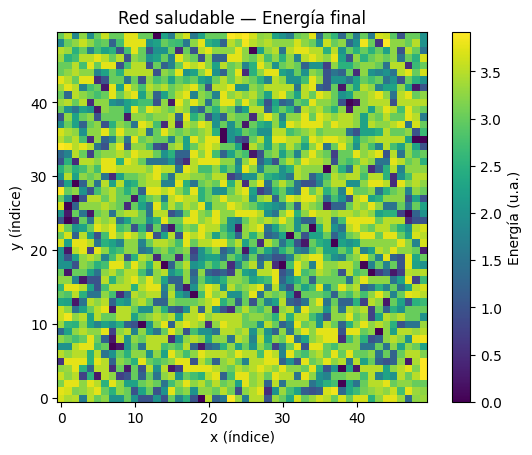

In [23]:
plt.imshow(E_fin_sano, origin='lower')
plt.title("Red saludable — Energía final")
plt.xlabel("x (índice)")
plt.ylabel("y (índice)")
plt.colorbar(label="Energía (u.a.)")
plt.show()


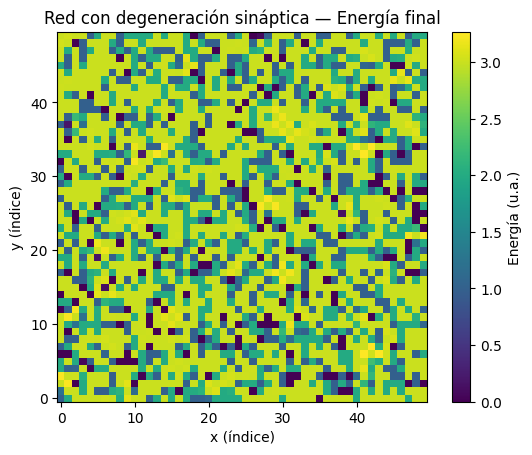

In [24]:
plt.imshow(E_fin_deg, origin='lower')
plt.title("Red con degeneración sináptica — Energía final")
plt.xlabel("x (índice)")
plt.ylabel("y (índice)")
plt.colorbar(label="Energía (u.a.)")
plt.show()


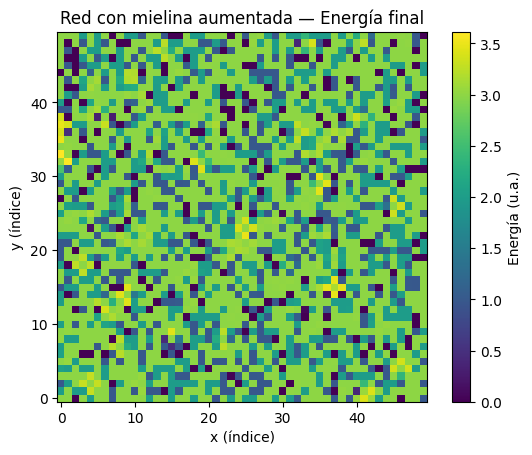

In [25]:
plt.imshow(E_fin_mielina, origin='lower')
plt.title("Red con mielina aumentada — Energía final")
plt.xlabel("x (índice)")
plt.ylabel("y (índice)")
plt.colorbar(label="Energía (u.a.)")
plt.show()


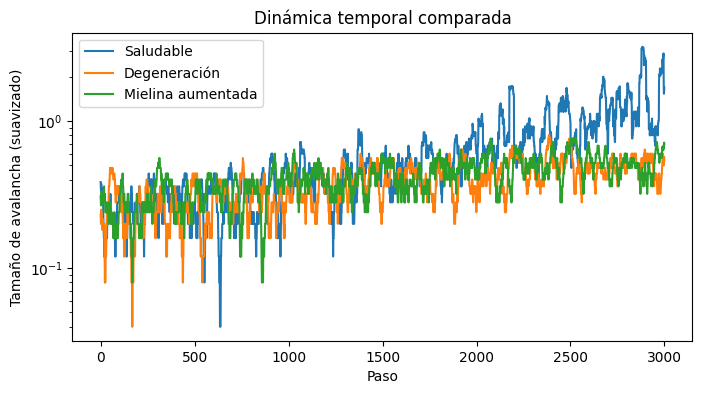

In [21]:
# dinámica temporal comparada (suavizar para ver tendencia)
plt.figure(figsize=(8,4))
plt.plot(pd.Series(ava_saludable).rolling(25, center=True, min_periods=1).mean(), label='Saludable')
plt.plot(pd.Series(ava_deg).rolling(25, center=True, min_periods=1).mean(), label='Degeneración')
plt.plot(pd.Series(ava_mielina).rolling(25, center=True, min_periods=1).mean(), label='Mielina aumentada')
plt.yscale('log')
plt.xlabel("Paso")
plt.ylabel("Tamaño de avalancha (suavizado)")
plt.title("Dinámica temporal comparada")
plt.legend(); plt.show()

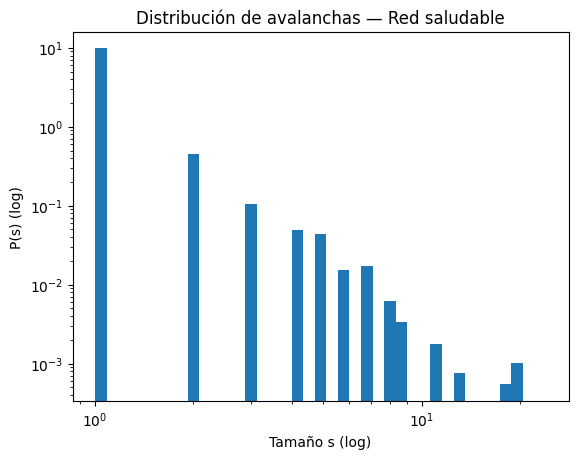

In [29]:
aval = ava_saludable[ava_saludable > 0]
bins = np.logspace(np.log10(aval.min()), np.log10(aval.max()), 40)

plt.hist(aval, bins=bins, density=True)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Tamaño s (log)")
plt.ylabel("P(s) (log)")
plt.title("Distribución de avalanchas — Red saludable")
plt.show()


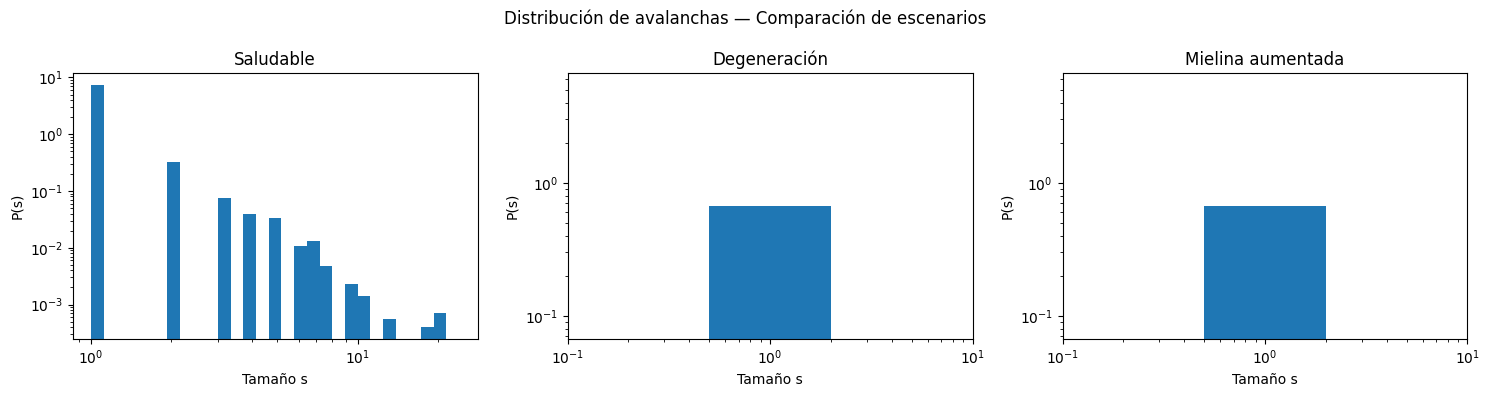

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

datasets = [ava_saludable, ava_deg, ava_mielina]
titulos = ["Saludable", "Degeneración", "Mielina aumentada"]

for ax, data, title in zip(axes, datasets, titulos):
    d = data[data > 0] # Filter out zero-sized avalanches

    if len(d) > 0:
        if d.min() == d.max():
            # Case: all non-zero avalanches have the same size (e.g., all 1s)
            single_val = d.min()
            # Create log-spaced bins that span around the single value
            # This ensures np.logspace gets distinct start/end and hist works.
            # We'll use 2 bins to represent a single point effectively
            bins = np.logspace(np.log10(single_val * 0.5), np.log10(single_val * 2), num=2)

            ax.hist(d, bins=bins, density=True)
            ax.set_xscale("log")
            ax.set_yscale("log")

            # Manually set x and y limits to ensure they are strictly positive for log scale
            ax.set_xlim(single_val * 0.1, single_val * 10) # Span a decade around the value
            # Set y-limit based on expected density height for a single bin
            # The density will be 1 / (bin_width) if there's only one unique value
            bin_width = single_val * 2 - single_val * 0.5
            max_density = 1.0 / bin_width if bin_width > 0 else 1.0 # Avoid division by zero if somehow bin_width is 0
            ax.set_ylim(max_density * 0.1, max_density * 10) # Span around the density value

        else:
            # Case: avalanches have a range of positive sizes
            bins = np.logspace(np.log10(d.min()), np.log10(d.max()), 30)
            ax.hist(d, bins=bins, density=True)
            ax.set_xscale("log")
            ax.set_yscale("log")
    else:
        # Case: no positive avalanches, plot an empty log-log plot (or just labels)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(0.1, 10) # Set default log limits for empty plot
        ax.set_ylim(0.1, 10) # Set default log limits for empty plot

    ax.set_title(title)
    ax.set_xlabel("Tamaño s")
    ax.set_ylabel("P(s)")

plt.suptitle("Distribución de avalanchas — Comparación de escenarios")
plt.tight_layout()
plt.show()
